In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from patsy import dmatrices
from scipy.stats import ttest_1samp
wd = "/Users/timvigers/Documents/Work/Viral Shah/ADA 2022/"

## Data
- Participants with HbA1c >= 6.5 were excluded from Kaan's CGM dataset. The remaining participants were combined with publicly available data on non-diabetics from the JAEB (https://public.jaeb.org/datasets/diabetes).
- For each participant, mean blood glucose was calculated from CGM data, and GMI calculated according to the standard equation (3.31 + 0.02392 * MBG). 
- GMI was compared to lab HbA1c, and a new GMI regression equation was estimated for this population. 

In [2]:
# Import Kaan's data
df = pd.read_csv(wd + "Data_Clean/analysis_data.csv",usecols=["14 Day Mean","HbA1c"])
# Only HbA1c < 6.5
df = df[df["HbA1c"] < 6.5]
df.columns = ["HbA1c","MBG"]
df = df[["MBG","HbA1c"]]
df["MBG"] = [round(m,2) for m in df["MBG"]]
# Add JAEB data
jaeb_cgm = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabDeviceCGM.csv")
jaeb_cgm = jaeb_cgm[jaeb_cgm["RecordType"] == "CGM"]
# Split by ID
dataframes = []
for _, d in jaeb_cgm.groupby(["PtID"]):
    dataframes.append(d)
# Calculate mean glucose for each participant
mean_bgs = {"PtID":[],"MBG":[]}
for d in dataframes:
    mean_bgs["PtID"].append(d["PtID"].iloc[0])
    mean_bgs["MBG"].append(round(d["Value"].mean(),2))
mean_bgs = pd.DataFrame(mean_bgs)
# Add HbA1c
jaeb_a1c = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabScreening.csv",usecols=["PtID","HbA1c"])
jaeb_a1c["PtID"] = [str(p) for p in jaeb_a1c["PtID"]]
mean_bgs["PtID"] = [str(p) for p in mean_bgs["PtID"]]
mean_bgs = mean_bgs.merge(jaeb_a1c,on = "PtID",how="left")
mean_bgs = mean_bgs[["MBG","HbA1c"]]
# Combine
df = pd.concat([df,mean_bgs])
# Calculate GMI
df["GMI"] = [3.31 + 0.02392*m for m in df["MBG"]]
df["Diff"] = df["HbA1c"] - df["GMI"]
df.reset_index(inplace=True)
# Split by HbA1c < 5.7 and 5.7 - 6.5
nondiab = df[df['HbA1c'] < 5.7]
prediab = df[(df['HbA1c'] >= 5.7) & (df['HbA1c'] <6.5)]

# HbA1c < 5.7

## Mean Glucose and HbA1c
Red line indicates GMI regression line.

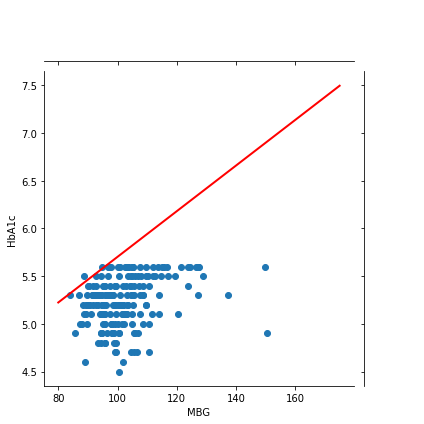

In [3]:
grid = sns.JointGrid(x=nondiab["MBG"],y=nondiab["HbA1c"])
grid.plot_joint(plt.scatter)
plt.plot([80,175],[5.2236,7.496], linewidth=2, color = "r");

## Differences between HbA1c and GMI

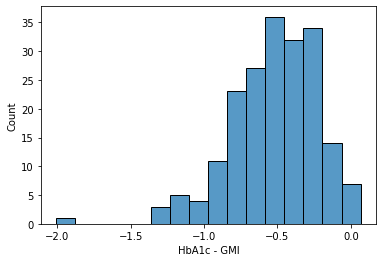

In [4]:
sns.histplot(data=nondiab, x="Diff")
plt.xlabel("HbA1c - GMI");

In [5]:
t = ttest_1samp(nondiab["Diff"],popmean = 0)

The differences between HbA1c and GMI were largely negative, suggesting that the standard GMI equation overestimates HbA1c in this cohort. On average, GMI was 0.5% higher, and this was significantly different from 0 (p < 0.0001).

## Regression Results

In [6]:
outcome,predictors = dmatrices("HbA1c ~ MBG",data = nondiab)
reg = OLS(outcome,predictors).fit()

In [7]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  HbA1c   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     18.80
Date:                Thu, 23 Dec 2021   Prob (F-statistic):           2.32e-05
Time:                        09:35:20   Log-Likelihood:                -1.5123
No. Observations:                 197   AIC:                             7.025
Df Residuals:                     195   BIC:                             13.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5017      0.171     26.386      0.000       4.165       4.838
MBG            0.0072      0.002      4.336      0.000       0.004       0.010
==============================================================================
Omnibus:                       12.517   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.627
Skew:                          -0.644   Prob(JB):                      0.00110
Kurtosis:                       2.983   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on this dataset, the regression equation for GMI would be:

GMI = 3.4551 + 0.0180 * MBG

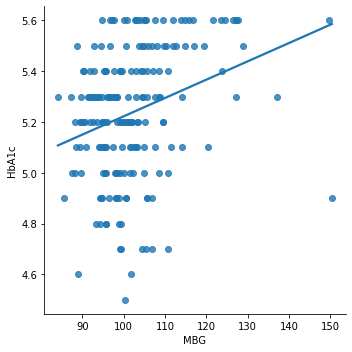

In [8]:
sns.lmplot(x="MBG",y="HbA1c",data=nondiab,ci=None);

# HbA1c 5.7 - 6.5
## Mean Glucose and HbA1c
Red line indicates GMI regression line.

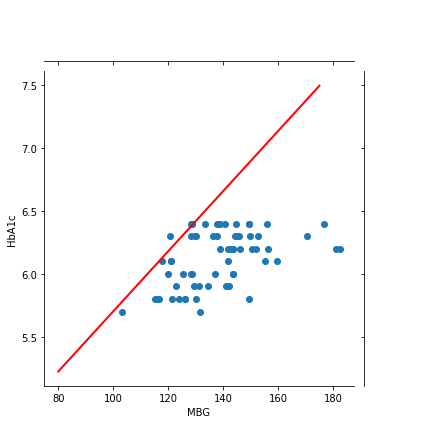

In [9]:
grid = sns.JointGrid(x=prediab["MBG"],y=prediab["HbA1c"])
grid.plot_joint(plt.scatter)
plt.plot([80,175],[5.2236,7.496], linewidth=2, color = "r");

## Differences between HbA1c and GMI

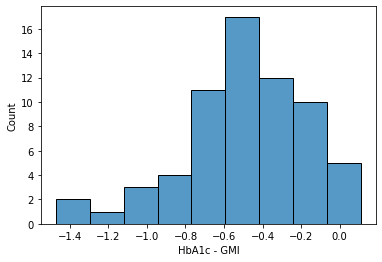

In [10]:
sns.histplot(data=prediab, x="Diff")
plt.xlabel("HbA1c - GMI");

In [14]:
t = ttest_1samp(prediab["Diff"],popmean = 0)

-0.49032615384615386

The differences between HbA1c and GMI were largely negative, suggesting that the standard GMI equation overestimates HbA1c in this cohort. On average, GMI was 0.5% higher, and this was significantly different from 0 (p < 0.0001).

## Regression Results

In [12]:
outcome,predictors = dmatrices("HbA1c ~ MBG",data = prediab)
reg = OLS(outcome,predictors).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  HbA1c   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     16.77
Date:                Thu, 23 Dec 2021   Prob (F-statistic):           0.000122
Time:                        09:35:20   Log-Likelihood:                 14.701
No. Observations:                  65   AIC:                            -25.40
Df Residuals:                      63   BIC:                            -21.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2418      0.217     24.121      0.000       4.808       5.676
MBG            0.0064      0.002      4.095      0.000       0.003       0.010
==============================================================================
Omnibus:                        9.484   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                2.990
Skew:                           0.021   Prob(JB):                        0.224
Kurtosis:                       1.950   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

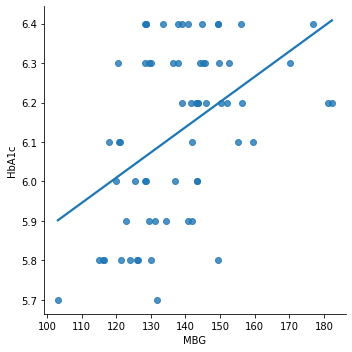

In [13]:
sns.lmplot(x="MBG",y="HbA1c",data=prediab,ci=None);